In [1]:
import os
import re
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sentence_transformers import SentenceTransformer, models

import warnings 
warnings.filterwarnings('ignore')

/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Разведочный анализ данных

In [2]:
pd.set_option("max_colwidth", 100)

In [3]:
data = pd.read_csv('data/topic_modeling_task_sample_trainPart.csv')
display(data.head(2))
display(data.tail(2))

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME
0,3,7,"5,01000641613474E+017",добрый_день. это клиентский_менеджер виктория сбер бизнес звоню вам как индивидуальный_предприни...,2021-02-16,Бизнес-карта
1,6,15,"5,01001121614156E+017",добрый_день. меня зовут клиентский_менеджер_сбербанк прописано звоню вам как индивидуальный_пред...,2021-02-24,Зарплатные проекты


,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME
42763,138899,350797,"5,01035571614254E+017",добрый_день. вас персональный_менеджер сбер бизнес по по удобно говорить,2021-02-25,Бизнес-карта
42764,138905,350816,"5,01036981613722E+017",добрый_день. здравствуйте меня зовут сбербанк блок сбер бизнес звоню вам по и по удобно разговар...,2021-02-19,Бизнес-карта


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42765 entries, 0 to 42764
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0.1                     42765 non-null  int64 
 1   Unnamed: 0                       42765 non-null  int64 
 2   ucid                             42765 non-null  object
 3   text_employer                    42765 non-null  object
 4   date                             42765 non-null  object
 5   ACTION_ITEM_RESULT_PRODUCT_NAME  42765 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


Мы видимо, что у нас есть три потенциальных столбца, которые можно считать уникальными индексами: 2 без названия, 1 - ucid.
Проверим их на наличие дубликатов.

In [5]:
display(data[data['Unnamed: 0'].duplicated()])
display(data[data['Unnamed: 0.1'].duplicated()])

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME


,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME


Видим, что столбцы без названия можно использовать в качестве уникальных id.

Также мы видим, что столбец ucid представлен строковым типом данных, проверим уникальны ли там записи.

In [6]:
data[data['ucid'].duplicated()]

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME
10,37,112,"5,01008001613546E+017",добрый_день. это ваш персональный_менеджер_сбербанк бизнес я вам звоню а как индивидуальный_пред...,2021-02-17,Бизнес-карта
11,38,113,"5,01008001613546E+017",сбербанк_бизнес меня зовут чем могу помочь. не поняла вас давайте проверим как могу к вам обраща...,2021-02-17,Бизнес-карта
27,97,306,"5,01022961613547E+017",добрый_день. персональный_менеджер ваш сбербанк_бизнес звоню вам как индивидуальный_предпринимат...,2021-02-17,Бизнес-карта
36,144,426,"5,01032991613725E+017",добрый_день это клиентский_менеджер_сбербанк удобно говорить. пришла у меня информация по почте ...,2021-02-19,Зарплатные проекты
40,155,466,"5,01037061613734E+017",добрый_день это. ваш персональный_менеджер сбер бизнес звоню вам по организации они за принт рос...,2021-02-19,Открытие банковского счета
...,...,...,...,...,...,...
42700,138714,350349,"1,11130056616141E+019",сбербанк_бизнес здравствуйте. нужно обратиться в отделение_банка по месту ведения счета а там э ...,2021-02-24,Зарплатные проекты
42715,138778,350489,"5,01010101613485E+017",здравствуйте меня зовут предыдущие специалисту озвучил что интересует интернет эквайринга все ве...,2021-02-16,Эквайринг
42720,138787,350508,"5,01011771613391E+017",сбербанк_бизнес здравствуйте. и скажите название организации. уже коллега сейчас к сожалению вас...,2021-02-15,Открытие банковского счета
42733,138810,350565,"5,01016821614144E+017",сбербанк_бизнес здравствуйте. уточните пожалуйста организации. хорошо соединить. сбербанк блок с...,2021-02-24,Зарплатные проекты


Нет, записи не уникальны, есть 2042 одинаковых ucid. При этом по одинаковым ucid разные диалоги. С учетом того, что мы не хотим отбрасывать данные просто так и с учетом того, что от нас по заданию требуется, чтобы это поле было в ответе, но прямо не указано, что нужно производить какие-либо его преобразования, то оставим это поле как есть.

Проверим, встречаются ли у нас дубликаты диалогам.

In [7]:
data[data['text_employer'].duplicated()]

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME
719,2414,6073,"5,01013431613562E+017",добрый_день,2021-02-17,Бизнес-карта
991,3344,8406,"5,01036531614147E+017",добрый_день,2021-02-24,Зарплатные проекты
1128,3799,9573,"5,01133571613472E+017",добрый_день,2021-02-16,Зарплатные проекты
1201,4040,10206,"5,01027521613561E+017",нет,2021-02-17,Зарплатные проекты
1264,4266,10818,"5,01076721613803E+017",добрый_день,2021-02-20,Бизнес-карта
...,...,...,...,...,...,...
42407,137663,347779,"5,01112981613377E+017",добрый_день,2021-02-15,Бизнес-карта
42557,138154,348918,"5,01043821614155E+017",добрый_день. меня зовут,2021-02-24,Бизнес-карта
42582,138259,349188,"5,01065971614233E+017",добрый_день,2021-02-25,Открытие банковского счета
42655,138552,349976,"5,01130171613726E+017",добрый_день,2021-02-19,Зарплатные проекты


Да, у нас есть 581 повторяющийся диалог. Из данных выше видно, что, главным образом, они связаны с короткими диалогами, которые ограничивались лишь приветствием.

Далее проанализируем целевые классы - поле ACTION_ITEM_RESULT_PRODUCT_NAME

In [8]:
data['ACTION_ITEM_RESULT_PRODUCT_NAME'].value_counts()

ACTION_ITEM_RESULT_PRODUCT_NAME
Бизнес-карта                  19427
Зарплатные проекты            12413
Открытие банковского счета     6643
Эквайринг                      4282
Name: count, dtype: int64

Видно, что есть определенный дисбаланс классов.

Примерно оценим длину диалогов по количеству слов

In [9]:
data['len_in_words'] = data['text_employer'].apply(lambda x: len(x.split(' ')))

In [10]:
data.pivot_table(index='ACTION_ITEM_RESULT_PRODUCT_NAME', values='len_in_words', aggfunc=['mean', 'median', 'max', 'min'])

,mean,median,max,min
,len_in_words,len_in_words,len_in_words,len_in_words
ACTION_ITEM_RESULT_PRODUCT_NAME,,,,
Бизнес-карта,212.234159,145.0,2313,1
Зарплатные проекты,160.113752,108.0,2877,1
Открытие банковского счета,145.315821,105.0,2532,1
Эквайринг,188.852405,122.0,2667,1


Из интересного: видно, что диалоги по зарплатным проектам и открытию банковсокго счета значительно короче, чем диалоги по бизнес-картам.

Отдельно посмотрим на короткие диалоги

In [11]:
data[data['len_in_words'] <= 20]

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME,len_in_words
7,26,74,"5,01005691614238E+017",добрый_день. сбербанк блок сбер бизнес менеджер вам удобно разговаривать сейчас. могу ли я вам п...,2021-02-25,Зарплатные проекты,18
19,74,232,"5,01016981613395E+017",добрый_день что может. это ваш персональный_менеджер сбер бизнес звоню по организации удобно сей...,2021-02-15,Бизнес-карта,20
47,179,535,"5,01043491614227E+017",конечно,2021-02-25,Зарплатные проекты,1
51,196,574,"5,01047511614175E+017",добрый_день. это ваш персональный_менеджер звоню вам как индивидуальный_предприниматель,2021-02-24,Открытие банковского счета,8
77,309,874,"5,01072711613732E+017",добрый вечер. прошу прощения перезвоню вам всего доброго,2021-02-19,Зарплатные проекты,8
...,...,...,...,...,...,...,...
42743,138846,350678,"5,01025851613739E+017",добрый_день,2021-02-19,Открытие банковского счета,1
42744,138848,350684,"5,01026361613464E+017",добрый_день. здравствуйте пао сбербанк блок сбер бизнес обслуживание лишних лицам удобно говорит...,2021-02-16,Зарплатные проекты,18
42751,138858,350710,"5,01029101613726E+017",там добрый_день. персональный_менеджер_сбербанк бог сбер бизнес звоню вам как индивидуальный_пре...,2021-02-19,Бизнес-карта,17
42753,138864,350724,"5,01029701613398E+017",добрый_день. сбербанк_клиентский_менеджер звоню вам как предпринимателю удобно сейчас говорить. ...,2021-02-15,Открытие банковского счета,11


Видно, что такие диалоги содержат приветствие и минимальное описание причины звонка, из которой нельзя понять настоящую цель. Например "добрый день" - "Открытие банковоского счета".

Но при этом они имеют целевую метку. Вероятно, это связано с тем, что занимаясь исходящими обзвонами, мы знали какая цель звонка изначально.

Но если мы создаем модель-классификатор, то такие короткие примеры только добавят шума к нашим данным.

А при тестировании мы, скорее всего, будем на них ошибаться в 75% случаев.

## Предобработка данных

Из данных видно, что некоторые слова типа "добрый_день" написан через подчеркивание. Мы бы хотели нормализовать наши тексты и избавиться от подчеркиваний.

In [12]:
data['text_employer'] = data['text_employer'].apply(lambda x: x.replace('_', ' ').lower().strip())

Далее разобьем наши данные на обучающую и тестовую выборку.

Сделаем сплит стратифицированным и оставим на тест 15% примеров.

In [13]:
train, test = train_test_split(data, test_size=0.15, random_state=42, stratify=data['ACTION_ITEM_RESULT_PRODUCT_NAME'])

Мы помним, что в данных у нас есть дубликаты по диалогам. Для тестовой выборки оставим дубликаты.

Но для обучающей их следует убрать, чтобы избежать переобучения.

In [14]:
train = train[~train['text_employer'].duplicated()].reset_index(drop=True)

Также, как мы уже говорили из обучающей выборки лучше убрать короткие диалоги.

In [15]:
train = train[train['len_in_words'] >= 20].reset_index(drop=True)

In [16]:
test[test['len_in_words'] < 20]

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,ACTION_ITEM_RESULT_PRODUCT_NAME,len_in_words
37714,122588,309512,"5,01057661613737E+017",здравствуйте меня зовут виктория сбербанк бизнес обращаюсь индивидуальный предприниматель смород...,2021-02-19,Бизнес-карта,18
22508,73296,185052,"5,01063971613562E+017",добрый день. что персональный менеджер сбербанк блок сбер бизнес звоню вам как индивидуальный. а...,2021-02-17,Эквайринг,14
25073,81493,205625,"5,01146911613453E+017",добрый день. это персональный менеджер сбербанк бизнес я звоню вам как индивидуальный предприним...,2021-02-16,Бизнес-карта,18
9290,30403,77129,"5,01140031613642E+017",добрый день. меня зовут эльвиром персональный менеджер звоню вам как незавершенного предпринимаю...,2021-02-18,Зарплатные проекты,18
39632,128832,325325,"5,01060221613618E+017",добрый день. это ваш персональный менеджер сбербанк блок звоню вам как предпринимателя удобно се...,2021-02-18,Бизнес-карта,18
...,...,...,...,...,...,...,...
8069,26340,66844,"5,01113801613733E+017",добрый день еще раз верно. сбербанк. а еще заняты все поняла тогда больше вас беспокоит всего до...,2021-02-19,Зарплатные проекты,16
32342,105092,265359,"5,01014561613741E+017",ну,2021-02-19,Бизнес-карта,1
28237,91690,231241,"5,0114043161346E+017",это вообще вот,2021-02-16,Зарплатные проекты,3
11112,36284,91876,"5,01051511614145E+017",записываю. все хорошо поняла спасибо большое. здравствуйте,2021-02-24,Зарплатные проекты,7


In [17]:
test = test[test['len_in_words'] >= 20].reset_index(drop=True)

## Обучение модели предсказания темы диалога

В качестве бейзлайна попробуем построить следующую модель:

- для векторизации текстов возьмем tf_idf;
- обучим логистическую регрессию над этими векторами.

In [18]:
# уберем из текстовых данных точки и прочие некириллические символы
train['text_prep'] = train['text_employer'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', '', x).lower())
test['text_prep'] = test['text_employer'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', '', x).lower())

test.drop(columns=['len_in_words', 'text_prep']).to_csv('data/test_set.csv', index=False)

In [19]:
# сформируем список стоп-слов
stopwords = ['добрый', 'день', 'менеджер', 'здравствуйте', 'свидания', 'благодарю', 'э', 'зовут', 
            'персональный', 'сбербанк', 'сбер', 'клиентский', 'а', 'звоню', 'я', 'меня', 'это']

In [20]:
%%time

# создадим pipeline из tf_idf и лог.регрессии и переберем некоторые гиперпараметры по сетке

tf_idf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5, use_idf=True, stop_words=stopwords)
log_reg = LogisticRegression(solver='saga')

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

tf_log_reg_pipe = Pipeline([('tf_idf', tf_idf),
                            ('log_reg', log_reg)])
                           
parameters = {'tf_idf__ngram_range' :((1, 1), (1, 2), (2, 2)),
              'tf_idf__max_features': range(4000, 16001, 4000),
              'log_reg__C': [0.1, 1, 5],
              'log_reg__class_weight': (None, 'balanced')}
                           
grid = GridSearchCV(tf_log_reg_pipe, parameters, cv=skf, n_jobs=-1, scoring='accuracy', verbose=1)
grid.fit(train['text_prep'], train['ACTION_ITEM_RESULT_PRODUCT_NAME'])

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrejvaluhov/Documents/test_tasks/svcb_test/.scb_test/lib/python3.9/site-packages/sklearn/li

CPU times: user 45.7 s, sys: 27.9 s, total: 1min 13s
Wall time: 19min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(min_df=5,
                                                        stop_words=['добрый',
                                                                    'день',
                                                                    'менеджер',
                                                                    'здравствуйте',
                                                                    'свидания',
                                                                    'благодарю',
                                                                    'э',
                                                                    'зовут',
                                                                    'персональный',
                                                                    'сбербанк',
                                                                    'сбер',
                                                                    'клиентский',
                                                                    'а',
                                                                    'звоню',
                                                                    'я', 'меня',
                                                                    'это'],
                                                        sublinear_tf=True)),
                                       ('log_reg',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.1, 1, 5],
                         'log_reg__class_weight': (None, 'balanced'),
                         'tf_idf__max_features': range(4000, 16001, 4000),
                         'tf_idf__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='accuracy', verbose=1)

In [21]:
print(grid.best_params_)
print(grid.best_score_)

{'log_reg__C': 1, 'log_reg__class_weight': None, 'tf_idf__max_features': 16000, 'tf_idf__ngram_range': (1, 2)}
0.8162836541972331


In [22]:
# сохраним лучший пайплайн
os.makedirs('models', exist_ok=True)
with open('models/fitted_pipeline.pkl', 'wb') as fd:
    joblib.dump(grid.best_estimator_, fd) 

In [23]:
test['prediction'] = grid.best_estimator_.predict(test['text_employer'])

In [24]:
label2id = {'Бизнес-карта' : 1, 
            'Зарплатные проекты': 2, 
            'Открытие банковского счета': 3, 
            'Эквайринг': 4,
            }

In [25]:
def vis(data, label2id, truth_col='ACTION_ITEM_RESULT_PRODUCT_NAME', pred_col='prediction'):
    
    print(classification_report(data[truth_col], data[pred_col]))
    
    cf = confusion_matrix(data[truth_col], data[pred_col])
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    s = sns.heatmap(cf, linewidths=1, annot=True, ax=ax, cmap='Blues', fmt='g', cbar=False,
                    xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()))
    plt.xticks(rotation=30)
    
    s.set_xlabel('Предсказание', fontsize=10)
    s.set_ylabel('Факт')

                            precision    recall  f1-score   support

              Бизнес-карта       0.81      0.92      0.86      2672
        Зарплатные проекты       0.83      0.78      0.81      1710
Открытие банковского счета       0.76      0.67      0.71       908
                 Эквайринг       0.90      0.73      0.80       590

                  accuracy                           0.82      5880
                 macro avg       0.83      0.77      0.80      5880
              weighted avg       0.82      0.82      0.82      5880



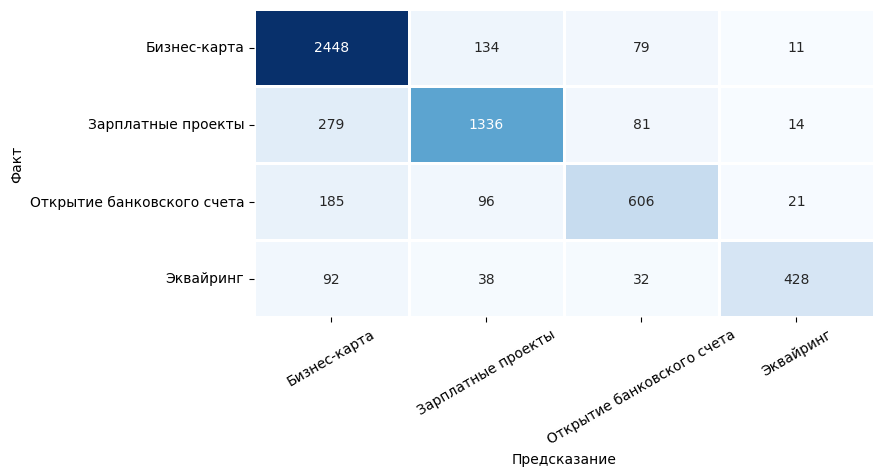

In [26]:
vis(test, label2id)

**Выводы**:
- accuracy на тестовом датасете с отброшенными короткими диалогами составила 0.82;
- при этом самым слабо предсказываемым классом оказалось "Открытие банковского счета" в частности потому, что верно идентифицировано было только 67% примеров из этого класса, а четверть предсказаний этого класса оказалась ложной.

In [27]:
def get_predictions(path_to_file='data/test_set.csv', path_to_model='models/fitted_pipeline.pkl'):
    
    """Функция для предсказания темы диалога по передаваемому csv-файлу"""
    
    data = pd.read_csv(path_to_file)
    
    if 'ucid' not in data.columns or 'text_employer' not in data.columns:
        print('Передайте корректный файл с полями ucid и text_employer')
        return
    
    # предобработка входных с учетом известных проблем
    data['text_employer'] = data['text_employer'].apply(lambda x: x.replace('_', ' ').lower().strip())
    data['text_employer'] = data['text_employer'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁ ]', '', x).lower())
    data['len_in_words'] = data['text_employer'].apply(lambda x: len(x.split(' ')))
    
    # загрузим обученный пайплайн
    pipeline = joblib.load(path_to_model)
    
    data['prediction'] = pipeline.predict(data['text_employer'])

    # в реальной жизни мы не захотим предсказывать на короткий диалог меньше 20 слов какую-то тему
    # поэтому для таких диалогов вернем новый класс "Требует уточнения"
    data['prediction'] = data.apply(lambda x: 'Требует уточнения' if x['len_in_words'] < 20 else x['prediction'], axis=1)
    
    label2id = {'Бизнес-карта' : 1, 
                'Зарплатные проекты': 2, 
                'Открытие банковского счета': 3, 
                'Эквайринг': 4,
                'Требует уточнения': 0}
    
    data['prediction'] = data['prediction'].map(label2id)
    data[['ucid', 'text_employer', 'prediction']].to_csv('data/prediction_result.csv', index=False)
    print('Результат предсказания записан в файл data/prediction_result.csv')

In [28]:
get_predictions()

Результат предсказания записан в файл data/prediction_result.csv
